# Learning with SARSA($\lambda$) & Linear function approximation 

## Yue Dong & Ali Emami
In this assignment, Ali and I want to demonstrate the experiments of performing SARSA($\lambda$) using linear function approximation. We use the SARSA algorithm for on-policy control, implemented using the backward-view (eligibility traces).

The difference of using linear function approximation in SARSA is that the action-value function Q(s,a) is approximated linearly by the function
$$Q(s,a,W)= \phi(s,a)^T * W$$ where W is a vector and $\phi$ a vector representing features.

## 1. Learning Easy21 with SARSA($\lambda$) and linear function approximation

The environment are defined in the script easy21game.py. The easy 21 is a simplified version of blackjack where the following rules are use:

- In each round, we draw cards with replacement from an infinite deck of cards. 
- Each draw results in a black (prob. 2/3) or red (prob. 2/3) card with values among 1 to 10. So there is no usable ace or face cards.
- At the beginning of the game, both player and dealer can only draw one black card
- Each turn the player may either stick or hit, hit means the player will draw another card, until he/she stick and the player side ends.
- Then the value of black cards are added and the value of red card are subtracted. 
- busted and lose the game if player's sum exceeds 21 or smaller than 1. Lose the game and receive reward -1.
- Otherwise, dealer's turn. dealer plays a fixed policy of sticks on any sum greater or equals to 17. If the dealer goes bust, then the player wins; otherwise, compare dealer's and player's card and the outcome is – win (reward +1), lose (reward -1), or draw (reward 0).

### Linear function approximation
To use linear function approximation, we define $\phi$ and W to be a vector of length 36. 
$\phi(s,a)$ is a binary feature vector with $3*6*2 = 36$ features. Each binary feature
 has a value of 1 if (s,a) lies within the cuboid of state-space corresponding to
 that feature, and the action corresponding to that feature. The cuboids have
 the following overlapping intervals:
   - dealer(s) = [1: 4]; [4: 7]; [7: 10]
   - player(s) = [1: 6]; [4: 9]; [7: 12]; [10: 15]; [13: 18]; [16: 21]
   - a = 1 (hit); a = 0 (stick)





In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 22 22:08:39 2017

@author: yuedong
"""

import os
os.chdir("/Users/yuedong/Downloads/comp767_easy21LA/")
#%%

from easy21game import Easy21
import numpy as np
from matplotlib import cm
#%%
env = Easy21()

#%% code the state-action paris into features

# INPUT
#   dealerState: card value of the dealer, integer between 1 and 10
# OUTPUT
#   boolean vector coding the dealer card to 3 intervals
def dealerFeatures(dealerState):
    dealerVec = np.array([dealerState in [1,2,3,4], dealerState in [4,5,6,7], 
                   dealerState in [7,8,9,10]]).astype('int')
    return np.where(dealerVec)[0]
  
    
# INPUT
#   playerState: sum of the player, integer between 1 and 21
# OUTPUT
#   boolean vector coding the player card interval on 6 bits
def playerFeatures(playerState):
    playerVec = np.array([playerState in [1,2,3,4,5,6], 
                     playerState in [4,5,6,7,8,9],
                     playerState in [7,8,9,10,11,12],
                     playerState in [10,11,12,13,14,15],
                     playerState in [13,14,15,16,17,18],
                     playerState in [16,17,18,19,20,21]]).astype('int')
    return np.where(playerVec)[0]


# INPUTS
#   s: state =(playerState,dealerState) (as defined in env._step)
#   a: action, integer: HIT(1) or STICK(0)
# returns a binary vector of length 36 representing the features
def phi(s, a):
    tmp = np.zeros(shape=(3,6,2)) #zeros array of dim 3*6*2
    #putting one where a feature is on
    for i in dealerFeatures(s[1]):
        for j in playerFeatures(s[0]):
            tmp[i,j,a] = 1 
    return(tmp.flatten()) #returning 'vectorized' (1-dim) array
#%%
class Sarsa_Agent:
    def __init__(self, environment, mlambda, gamma=1, step_size=0.01):

        self.env = environment
        self.mlambda = mlambda
        self.gamma = gamma
        self.step_size = step_size
        #initialize everything
#        self.Q = np.zeros((self.env.dealer_space,
#                           self.env.player_space, 
#                           self.env.nA))
         
        self.V = np.zeros((self.env.dealer_space,
                           self.env.player_space))
        
        self.W = np.zeros(36)
        self.E = np.zeros(36)
        
        self.iterations = 0
        
        
    # Q is simply the dot product of phi and w
    def cal_Q(self,s,a):
        return np.dot(phi(s,a),self.W)


          # get optimal action based on ε-greedy exploration strategy  
    def epsilon_greedy_action(self, state, epsilon=0.05):
        # action = 0 stick
        # action = 1 hit
        hit = 1
        stick = 0
        # epsilon greedy policy
        if np.random.random() < epsilon:
            r_action = hit if np.random.random()<0.5 else stick
            return r_action
        else:
            action = np.argmax([self.cal_Q(state,0),self.cal_Q(state,1)])
            return action
        
    
    def train(self, iterations):        
        # Loop episodes
        for episode in range(iterations):
            self.E = np.zeros(36)

            # get initial state for current episode
            s = self.env._reset()
            a = self.epsilon_greedy_action(s)
            a_next = a
            term = False
            #r = 0
            
            # Execute until game ends
            while not term:
                
                # execute action
                s_next, r, term = self.env._step(a)[0:3]
                q = self.cal_Q(s,a)
                                
                if not term:
                    # choose next action with epsilon greedy policy
                    a_next = self.epsilon_greedy_action(s_next)
                    q_next = self.cal_Q(s_next,a_next)
                    delta = r + self.gamma * q_next - q
                else:
                    delta = r - q
                
                
                self.E =  self.gamma * self.mlambda * self.E +phi(s,a)
                self.W = self.W + self.step_size * delta * self.E

                # reassign s and a
                s = s_next
                a = a_next


        self.iterations += iterations

        # Derive value function
        for d in range(self.env.dealer_space):
            for p in range(self.env.player_space):
                self.V[d,p] = max([self.cal_Q((p+1,d+1),0),self.cal_Q((p+1,d+1),1)])
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[x, y]

        X = np.arange(0, self.env.dealer_space, 1)
        Y = np.arange(0, self.env.player_space, 1)
        X, Y = np.meshgrid(X, Y)
        Z = get_stat_val(X, Y)
        
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf
#%%

agent = Sarsa_Agent(env, 0.5)
#%%
for i in range (1):
    agent.train(10000)

#print("learned values:",agent.V)
#agent.W

done  0 1 0
done  0 1 1
done  1 2 2
done  2 4 4
done  3 8 8
done  4 16 16
done  5 32 32
done  6 64 64
done  7 128 128
done  8 256 256
done  9 512 512
done  10 1024 1024
done  11 2048 2048
done  12 4096 4096
done  13 8192 8192
done  14 16384 16384
done  0 32768 32768


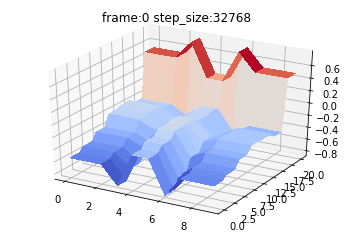

In [29]:
def animate(frame):
    i = agent.iterations
    step_size = i
    step_size = max(1, step_size)
    step_size = min(step_size, 2 ** 16)
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('frame:%s step_size:%s ' % (frame, step_size) )
    # plt.draw()
    fig.canvas.draw()
    print("done ", frame, step_size, i)
    return surf

#%%
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline 


mlambda = 0.2
agent = Sarsa_Agent(env,mlambda)
fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

# ani = animation.FuncAnimation(fig, animate, 32, repeat=False)
ani = animation.FuncAnimation(fig, animate, 15, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('Sarsa_Agent_easy21.gif', writer='imagemagick', fps=3)
# plt.show()

In [30]:
from IPython.display import Image
Image(url="Sarsa_Agent_easy21.gif")

## Discussion and Results

In [45]:
from IPython.display import Image
Image(url="comparison_with_different_lambda.png")

The above graph compares different algorithms we used for Easy21. 

- learning with different $\lambda$ makes a difference in learning, lower to intermediate values are learning better (0 to 0.4). We could conclude that MC control ($\lambda=1$) is learning the slowest among all different lambda values because MC has the highest variance among all sarsa($\lambda$) leaners. 

- With less variables to learn, function approximation decreases learning time in Easy21. Our last assignment presented the result without function approximation.  At iteration 3000, most values are still not accurate yet. In this assignment, at step 3000, we could see that the values are well approximations of the optimal values. 

- However, the fast learning is at the cost of some precision since the features are generalized.  The overlapping regions led to strange results, likely caused by having had certain states triggering multiple regions, and having the sum of their weights lead to values greater than one.  These regions should be removed—no significant benefit was observed from them.

## 2. Mountain-Car task

### (1) mountain car environment
We first implemented the environment of the mountain car based on the example 8.2 (first version of sutton's book).

In [32]:
'''
# mountain car has two variables: position(x-axis) and velocity
# -1.2 <= position <= 0.5
# -0.07 <= velocity <= 0.07
'''

from pylab import cos
import numpy as np

class mountainCar():
    
    def __init__(self):
        self._reset()
        self.nA = 3
        
        self.position_space = [-1.2, 0.5]
        self.velocity_space = [-0.07, 0.07]
        
        self.discrete_position_space = np.linspace(-1.2,0.5,30)
        self.discrete_velocity_space = np.linspace(-0.07,0.07,30)
        
        
    # each episode starts from a random position and velocity
    # which are choosen with uniformly within the ranges
    def _reset(self):
        self.position = np.random.uniform(low=-1.2, high=0.5, size=None)
        self.velocity = np.random.uniform(low=-0.07, high=0.07, size=None)
        return self.position, self.velocity

    def _step(self, action):
    #position,v = self.position, self.velocity
        if not action in (-1,0,1):
            print('Invalid action:', action)
            raise "StandardError"

        self.velocity += 0.001*action - 0.0025*cos(3*self.position)
        if self.velocity < -0.07:
            self.velocity = -0.07
        elif self.velocity >= 0.07:
            self.velocity = 0.07
            
        self.position += self.velocity
        if self.position >= 0.5:
            return None, -1
        if self.position < -1.2:
            self.position = -1.2
            self.velocity = 0.0
        return (self.position, self.velocity), -1

### (2) feature encoding with tile coding 
We encode the feature space of the mountaion car as 4 tilings of 8x8 grids with a shift of 1/4 of a tile size. We add one extra row and one extra column so that every point is covered by each tiling. Since we are doing control, the features $\phi(s,a)$ are defined based on states and actions.

In [33]:
import math
# this code is inspired from https://github.com/ctevans/.../Tilecoder.py

# mountain car has two variables: position(x-axis) and velocity
# -1.2 <= position <= 0.5
# -0.07 <= velocity <= 0.07

# devide the 2D space into an 8 by 8 grid
# then shift this grid with 1/4 of a tile width to obtain 4 tilings (partitions) 
numTiles = 8 
numTilings = 4

positionTileMove = ((0.5 + 1.2) / numTiles) / numTilings
velocityTileMove = ((0.07 + 0.07) / numTiles) /numTilings

# in order to make sure all points are covered after shifting 
# add one extra row and one extra column for shifting
# numver of total features  = 9x9x4
numFeatures = numTilings * (numTiles+1) * (numTiles+1)


# x = position, y = velocity
# note move a tiling by (a, b), then find the index of a point
# is the same as moving the points by (-a, -b)
# shift direction in this code is to the left-bottom corner
def tilecode(x,y,tileIndices):
    
    # find the distance of x to the leftmost position
    x = x + 1.2
    # find the distance of y to smallest velocity
    y = y + 0.07

    for i in range (numTilings):
        
        # in tiling i, we move a points by 
        # (-i*positionTileMove,i*velocityTileMove) for feature encoding
        xMove = i * (-positionTileMove)
        yMove = i * (-velocityTileMove)
	
        xTileIdx = int(numTiles * (x - xMove)/1.7)
        yTileIdx = int(numTiles * (y - yMove)/0.14)

        tileIndices[i] = i * 81 + ( yTileIdx * 9 + xTileIdx)
    
    
def tileCoderIndices(x,y):
    tileIndices = [-1]*numTilings
    tilecode(x,y,tileIndices)
    #print('Tile indices for input (%s,%s) are : '%(x,y), tileIndices)
    return tileIndices
                                                
#printTileCoderIndices(0.5,0.07)
#[-1, -1, -1, -1]
#Tile indices for input (0.5,0.07) are :  [80, 161, 242, 323]

# INPUTS
#   s: state =(position,velocity) 
#   a: action, integer: throttle reverse (-1), zero throttle (0), throttle forwards (1)
# returns a binary vector of length (4*9*9)*3 representing the features
def phi(s, a):
    tmp = np.zeros(shape=(4*9*9,3)) #zeros array of dim 3*6*2
    #putting one where a feature is on
    for i in tileCoderIndices(s[0],s[1]):
            tmp[i,a] = 1 
    return(tmp.flatten()) #returning 'vectorized' (1-dim) array

### (3) SARSA($\lambda$) with LA
We then modified SARSA($\lambda$) with LA for the mountain car problem.

finished in 2 steps
finished in 2 steps
finished in 3930 steps
finished in 3991 steps
finished in 585 steps
finished in 37 steps
finished in 2733 steps
finished in 2767 steps
finished in 1040 steps
finished in 1087 steps
finished in 1327 steps
finished in 1387 steps


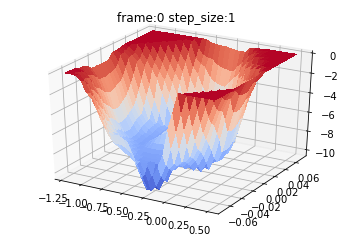

In [46]:
# ### (3) SARSA($\lambda$) with LA
# We then modified SARSA($\lambda$) with LA for the mountain car problem.

# In[63]:

class Sarsa_Agent:
    def __init__(self, environment, mlambda, gamma=1, step_size=0.01):

        self.env = environment
        self.mlambda = mlambda
        self.gamma = gamma
        self.step_size = step_size

        self.V = {}
#        self.V = np.zeros((len(self.env.discrete_position_space),
#                           len(self.env.discrete_velocity_space)))
        
        self.W = np.zeros(4*9*9*3)
        self.E = np.zeros(4*9*9*3)
        
        self.iterations = 0
        
        
    # Q is simply the dot product of phi and w
    def cal_Q(self,s,a):
        return np.dot(phi(s,a),self.W)


          # get optimal action based on ε-greedy exploration strategy  
    def epsilon_greedy_action(self, state, epsilon=0.05):
        # epsilon greedy policy
        if np.random.random() < epsilon:
            return np.random.choice([0,1,-1])
        else:
            action = np.argmax([self.cal_Q(state,-1),
                                self.cal_Q(state,0), 
                                self.cal_Q(state,1)])-1
            return action
        
    
    def train(self, iterations):        
        # Loop episodes
        for episode in range(iterations):
            self.E = np.zeros(4*9*9*3)

            # get initial state for current episode
            s = self.env._reset()
            #print("s:", s)
            a = self.epsilon_greedy_action(s)
            a_next = a
            couner = 0

            
            # Execute until game ends
            while s != None:
                
                # execute action
                s_next, r = self.env._step(a)
                q = self.cal_Q(s,a)
                                
                if s_next != None:
                    # choose next action with epsilon greedy policy
                    a_next = self.epsilon_greedy_action(s_next)
                    q_next = self.cal_Q(s_next,a_next)
                    delta = r + self.gamma * q_next - q
                else:
                    delta = r - q
                
                
                self.E =  self.gamma * self.mlambda * self.E +phi(s,a)
                self.W = self.W + self.step_size * delta * self.E

                # reassign s and a
                s = s_next
                a = a_next
                couner += 1 
                
        print("finished in %s steps"% couner)
        self.iterations += iterations
        

        ##### BUILD A DICTIONARY HERE
        # Derive value function
        for d in self.env.discrete_position_space:
            for p in self.env.discrete_velocity_space:
                self.V[(d,p)] = max([self.cal_Q((d,p),0),
                                   self.cal_Q((d,p),1), 
                                   self.cal_Q((d,p),-1)])
        #print(self.V)
                
    def plot_frame(self, ax):
        def get_stat_val(x, y):
            return self.V[(x, y)]

        X = self.env.discrete_position_space
        Y = self.env.discrete_velocity_space
        X, Y = np.meshgrid(X, Y)
        
        Z = np.zeros((len(self.env.discrete_position_space),
                      len(self.env.discrete_velocity_space)))
        for i in range(len(self.env.discrete_position_space)):
            for j in range(len(self.env.discrete_velocity_space)):
                Z[i,j] = get_stat_val(self.env.discrete_position_space[i],
                                      self.env.discrete_velocity_space[j])
        
        
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=cm.coolwarm, linewidth=0, antialiased=False)
        return surf
    
def animate(frame):
    i = agent.iterations
    #step_size = i
    step_size = 1
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('frame:%s step_size:%s ' % (frame, step_size) )
    # plt.draw()
    fig.canvas.draw()
    #print("done ", frame, step_size, i)
    return surf

#%%
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
get_ipython().magic(u'matplotlib inline')

env1 = mountainCar()
mlambda = 0.2
agent = Sarsa_Agent(env1,mlambda)
fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

# ani = animation.FuncAnimation(fig, animate, 32, repeat=False)
ani = animation.FuncAnimation(fig, animate, 10, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('Sarsa_Agent_mountaincar_1_episode_per_frame.gif', writer='imagemagick', fps=3)
# plt.show()

In [47]:
from IPython.display import Image
Image(url="Sarsa_Agent_mountaincar_1_episode_per_frame.gif")

finished in 15 steps
finished in 252 steps
finished in 200 steps
finished in 7 steps
finished in 66 steps
finished in 79 steps
finished in 70 steps
finished in 86 steps
finished in 11 steps
finished in 205 steps
finished in 91 steps
finished in 52 steps


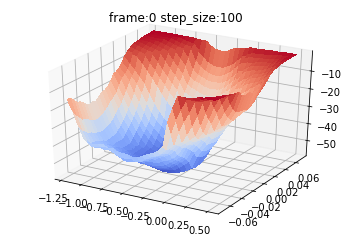

In [48]:
def animate(frame):
    i = agent.iterations
    #step_size = i
    step_size = 100
    agent.train(step_size)

    ax.clear()
    surf =  agent.plot_frame(ax)
    plt.title('frame:%s step_size:%s ' % (frame, step_size) )
    # plt.draw()
    fig.canvas.draw()
    #print("done ", frame, step_size, i)
    return surf

#%%
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
get_ipython().magic(u'matplotlib inline')

env1 = mountainCar()
mlambda = 0.2
agent = Sarsa_Agent(env1,mlambda)
fig = plt.figure("N100")
ax = fig.add_subplot(111, projection='3d')

# ani = animation.FuncAnimation(fig, animate, 32, repeat=False)
ani = animation.FuncAnimation(fig, animate, 10, repeat=False)

# note: requires gif writer; swap with plt.show()
ani.save('Sarsa_Agent_mountaincar_100_episode_per_frame.gif', writer='imagemagick', fps=3)
# plt.show()


In [49]:
from IPython.display import Image
Image(url="Sarsa_Agent_mountaincar_100_episode_per_frame.gif")

### Discussion and Conclusion

- I found that in the mountain car environment, tile coding seems to help generalize states better than easy21, and the values learned are smooth. 
- More episodes bring down the value estimations because all values are initialized as zero which are too optimistic. The more states we visited, the value estimations became worse for those states. As in our graph, within 10 episodes, the smallest value is around -8; if we ran 1000 episode, the smallest value is around -50. 
- Compare running 10 episodes or 1000 episodes, the latter learned faster to reach the goal. In the first ten episodes, some times it takes the car a few thousand steps to reach the goal. After 100 episodes, it averagely takes a few hundred steps to reach the goal. 